In [1]:
import sys
import os
from deepface import DeepFace
import tensorflow as tf
import numpy as np
import cv2
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
print(sys.version)
print(np.__version__)
print(tf.__version__)

3.10.15 | packaged by Anaconda, Inc. | (main, Oct  3 2024, 07:22:19) [MSC v.1929 64 bit (AMD64)]
1.26.4
2.10.1


In [2]:
def extract_pixels_from_image(image: np.ndarray, facial_area: dict) -> np.ndarray:
    """
    Extrae el área de la imagen basado en las coordenadas de 'facial_area' y devuelve
    el recorte como un array en formato float64.

    Args:
        image (np.ndarray): Imagen original cargada con OpenCV en formato uint8 BGR.
        facial_area (dict): Diccionario con las coordenadas 'x', 'y', 'w', 'h'.

    Returns:
        np.ndarray: El recorte del rostro en formato float64 y en el rango [0, 1].
    """
    x, y, w, h = facial_area['x'], facial_area['y'], facial_area['w'], facial_area['h']
    
    # Ajustar las coordenadas para evitar índices negativos
    x = max(0, x)
    y = max(0, y)
    
    # Recortar la imagen en la región del área facial
    face_crop = image[y:y+h, x:x+w]

    # Convertir el recorte a float64 y escalar a [0, 1]
    face_crop_float64 = face_crop.astype(np.float64) / 255.0
    
    return face_crop_float64

def extract_and_expand_faces(img_path: str, margin_ratio: float = 0.0) -> list:
    """
    Extrae rostros de una imagen y expande los bounding boxes según el margin_ratio.
    Args:
        img_path (str): Ruta de la imagen para procesar.
        margin_ratio (float): Proporción de expansión del bounding box. 
    Returns:
        List[Dict[str, Any]]: Lista de rostros detectados con bounding boxes ajustados.
    """
    # Cargar la imagen
    image = cv2.imread(img_path)

    # Detectar rostros con DeepFace usando el modelo RetinaFace
    faces = DeepFace.extract_faces(
        img_path=image,
        detector_backend='retinaface',
        enforce_detection=False
    )

    # Expande los bounding boxes
    for face_data in faces:
        facial_area = face_data['facial_area']
        
        # Obtener coordenadas originales
        x, y, w, h = facial_area['x'], facial_area['y'], facial_area['w'], facial_area['h']
        
        # Calcular margen adicional basado en el ratio
        margin_x = int(w * margin_ratio)
        margin_y = int(h * margin_ratio)
        
        # Expande el bounding box con el margen calculado
        facial_area['x'] = x - margin_x
        facial_area['y'] = y - margin_y
        facial_area['w'] = w + 2 * margin_x
        facial_area['h'] = h + 2 * margin_y

    for __face__ in faces:
        __face__['face'] = extract_pixels_from_image(image, __face__['facial_area'])
    
    return faces

def get_img_array_uint8(arraydata):
    img = arraydata
    #B, G, R = img.T
    #__bgr_img = np.array((B, G, R)).T
    #bgr_img = (__bgr_img*255).astype(np.uint8)
    bgr_img = (img*255).astype(np.uint8)
    return bgr_img


In [4]:
def get_people_list(path_people_ref:str)->list:
    # Ruta del directorio de referencia
    ref_directory = path_people_ref

    # Lista para almacenar los diccionarios de las personas
    list_dict = []

    # Recorrer cada subdirectorio en el directorio de referencia
    for person_name in os.listdir(ref_directory):
        person_path = os.path.join(ref_directory, person_name)
    
        # Verificar si es un directorio (nombre de persona)
        if os.path.isdir(person_path):
            # Listar las imágenes dentro del subdirectorio de la persona
            images = [img for img in os.listdir(person_path) if img.endswith(".png")]
            
            # Generar rutas completas con "/" como separador
            image_paths = [os.path.join(person_path, img).replace("\\", "/") for img in images]
        
            # Crear el diccionario para esta persona
            person_dict = {
                "name": person_name,
                "images": images,
                "images_paths": image_paths
            }
        
            # Añadir a la lista
            list_dict.append(person_dict)
    
    return list_dict

# Generar la lista de personas
list_dict_people = get_people_list("./data/classroom/ref/")

# Ejemplo de acceso y salida
print(list_dict_people[2])  # Diccionario del primer elemento

{'name': 'bernal-jaime', 'images': ['img-00.png', 'img-01.png', 'img-02.png', 'img-03.png', 'img-04.png'], 'images_paths': ['./data/classroom/ref/bernal-jaime/img-00.png', './data/classroom/ref/bernal-jaime/img-01.png', './data/classroom/ref/bernal-jaime/img-02.png', './data/classroom/ref/bernal-jaime/img-03.png', './data/classroom/ref/bernal-jaime/img-04.png']}


Extracting faces...
Comparing faces
Person: 1/20
Analyzing the person aparicio-azner
Extracting reference face...
100.000%
Drawing box...

Person: 2/20
Analyzing the person ayala-javier
Extracting reference face...
100.000%
Drawing box...

Person: 3/20
Analyzing the person bernal-jaime
Extracting reference face...
100.000%
Drawing box...

Person: 4/20
Analyzing the person caballero-luis
Extracting reference face...
100.000%
Drawing box...

Person: 5/20
Analyzing the person delatorre-pedro
Extracting reference face...
100.000%
Drawing box...

Person: 6/20
Analyzing the person diaz-julian
Extracting reference face...
100.000%
Drawing box...

Person: 7/20
Analyzing the person freitas-jeremy
Extracting reference face...
100.000%
Drawing box...

Person: 8/20
Analyzing the person gonzalez-edwar
Extracting reference face...
100.000%
Drawing box...

Person: 9/20
Analyzing the person justavino-michelle
Extracting reference face...
100.000%
Drawing box...

Person: 10/20
Analyzing the person marq

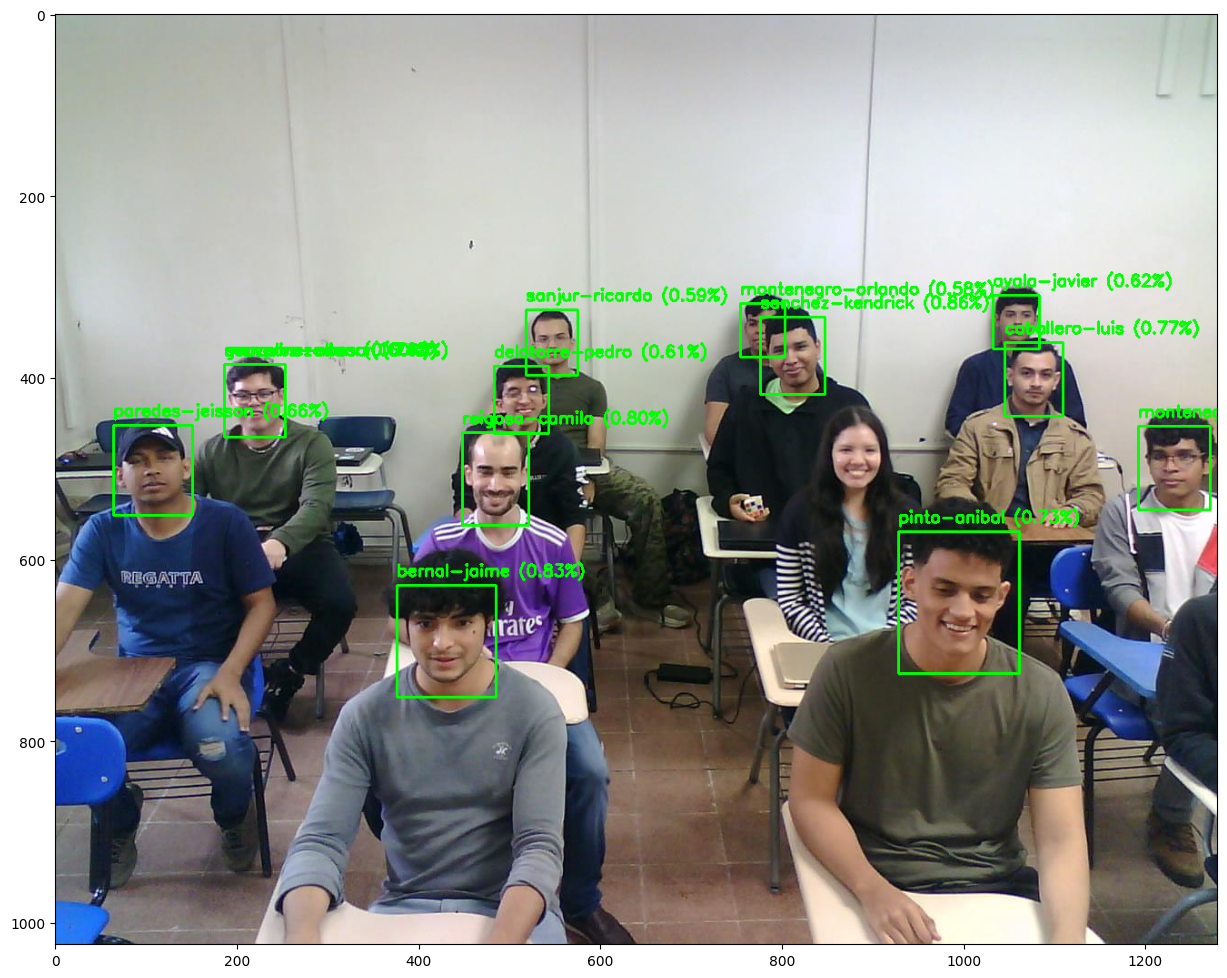

In [18]:
def recognize_person(
    analyze_faces: list, 
    ref_face: list, 
    metric_model_name: str = "Facenet512",
    metric_distance: str = "cosine",
    metric_threshold: float = 0.44
) -> list:
    """
    Reconoce a una persona comparando los rostros detectados en la imagen de análisis
    con el rostro de referencia, utilizando DeepFace.

    Args:
        analyze_faces (list): Lista de rostros detectados en la imagen de análisis.
        ref_face (list): Lista con el rostro objetivo (referencia).
        analyze_margin_ratio (float): Margen de expansión para los rostros analizados.
        ref_margin_ratio (float): Margen de expansión para el rostro de referencia.
        metric_model_name (str): Modelo a utilizar para la comparación.
        metric_distance (str): Métrica de distancia para la comparación.
        metric_threshold (float): Umbral para verificar si los rostros coinciden.

    Returns:
        list: Lista de diccionarios con información de los resultados para cada rostro.
    """
    if not ref_face or len(ref_face) == 0:
        print("Error: The reference face is empty.")
        return []
    
    # Obtener el rostro de referencia
    target_face_data = ref_face[0]
    target_face = target_face_data['face']
    array_bgr_target_face = (target_face * 255.0).astype(np.uint8)

    results = []
    total_faces = len(analyze_faces)

    # Iterar sobre cada rostro detectado en la imagen de análisis
    for i, face_data in enumerate(analyze_faces):
        # Progreso de la comparación
        loading = f"{(i / (total_faces - 1)) * 100:.3f}%"
        print("\r" + loading, end="")

        facial_area = face_data['facial_area']  # Bounding box
        face = face_data['face']
        array_bgr_face = (face * 255.0).astype(np.uint8)

        # Comparar el rostro detectado con el rostro de referencia
        result = DeepFace.verify(
            img1_path=array_bgr_target_face,
            img2_path=array_bgr_face,
            detector_backend="skip",
            model_name=metric_model_name,
            distance_metric=metric_distance,
            threshold=metric_threshold,
            enforce_detection=False
        )

        # Almacenar los resultados
        results.append({
            "index": i,
            "distance": result['distance'],
            "threshold": result['threshold'],
            "verified": result['verified'],
            "facial_area": facial_area
        })

    # Ordenar resultados por distancia
    results.sort(key=lambda x: x['distance'])

    # Imprimir resultados ordenados
    #for res in results:
        #print(f"Index: {res['index']} Distance: {res['distance']:.4f}")

    return results

def draw_verified_faces(image, result_list_dict, name_person="target"):
    """
    Dibuja los recuadros en la imagen basados en los resultados de la verificación.
    
    Args:
        image (np.ndarray): Imagen original en formato BGR.
        result_list_dict (list): Lista de resultados de verificación.
        name_person (str): Nombre del objetivo reconocido.
    
    Returns:
        np.ndarray: Imagen con los recuadros dibujados.
    """
    for result in result_list_dict:
        # Obtener coordenadas del área facial
        facial_area = result['facial_area']
        x, y, w, h = facial_area['x'], facial_area['y'], facial_area['w'], facial_area['h']

        # Verificar si el rostro es reconocido (verified=True)

        if result['verified']:
            color = (0, 255, 0)  # Verde
            confidence = 1.0 - result['distance']
            label = f"{name_person} ({confidence:.2f}%)"
            # Dibujar el recuadro y la etiqueta
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
            cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    return image

metrics = ["cosine", "euclidean", "euclidean_l2"]
models = ["Facenet", "Facenet512", "VGG-Face", "OpenFace", "DeepFace", "DeepID", "ArcFace", "Dlib", "SFace","GhostFaceNet"]

#cargar la imagen a analizar
path_analyze_image = "./data/classroom/rawdata/s2/recording_2024-11-13_10-45-09/frame-226.jpg"
image = cv2.imread(path_analyze_image)

#extraer los rostros de la imagen a analizar
print("Extracting faces...")
faces_data = extract_and_expand_faces(path_analyze_image, 0.2)

#print(result_list_dict)
index:int = 0
image_with_verified_face = image
print("Comparing faces")
list_dict_people = get_people_list("./data/classroom/ref/")

for dict_person in list_dict_people:
    
    print(f"Person: {index+1}/{len(list_dict_people)}")

    person_name:str = dict_person["name"]
    path_ref_img:str =  dict_person["images_paths"][0]
    print(f"Analyzing the person {person_name}")
    
    #extraer el rostro objetivo (face_target) de la imagen de referencia
    print("Extracting reference face...")
    target_face_data =  extract_and_expand_faces(path_ref_img, 0.18)
    result_list_dict = recognize_person(faces_data, target_face_data, metric_threshold=0.44)
    print("\nDrawing box...\n")
    image_with_verified_face = draw_verified_faces(image_with_verified_face, result_list_dict, name_person=person_name)
    
    index += 1

# Convertir BGR a RGB para mostrar con Matplotlib
image_rgb = cv2.cvtColor(image_with_verified_face, cv2.COLOR_BGR2RGB)

# Mostrar la imagen
plt.figure(figsize=(15, 15))
plt.imshow(image_rgb)
plt.axis('on')
plt.show()


Extracting faces...
Extracting reference face...
Comparing images...
100.000%

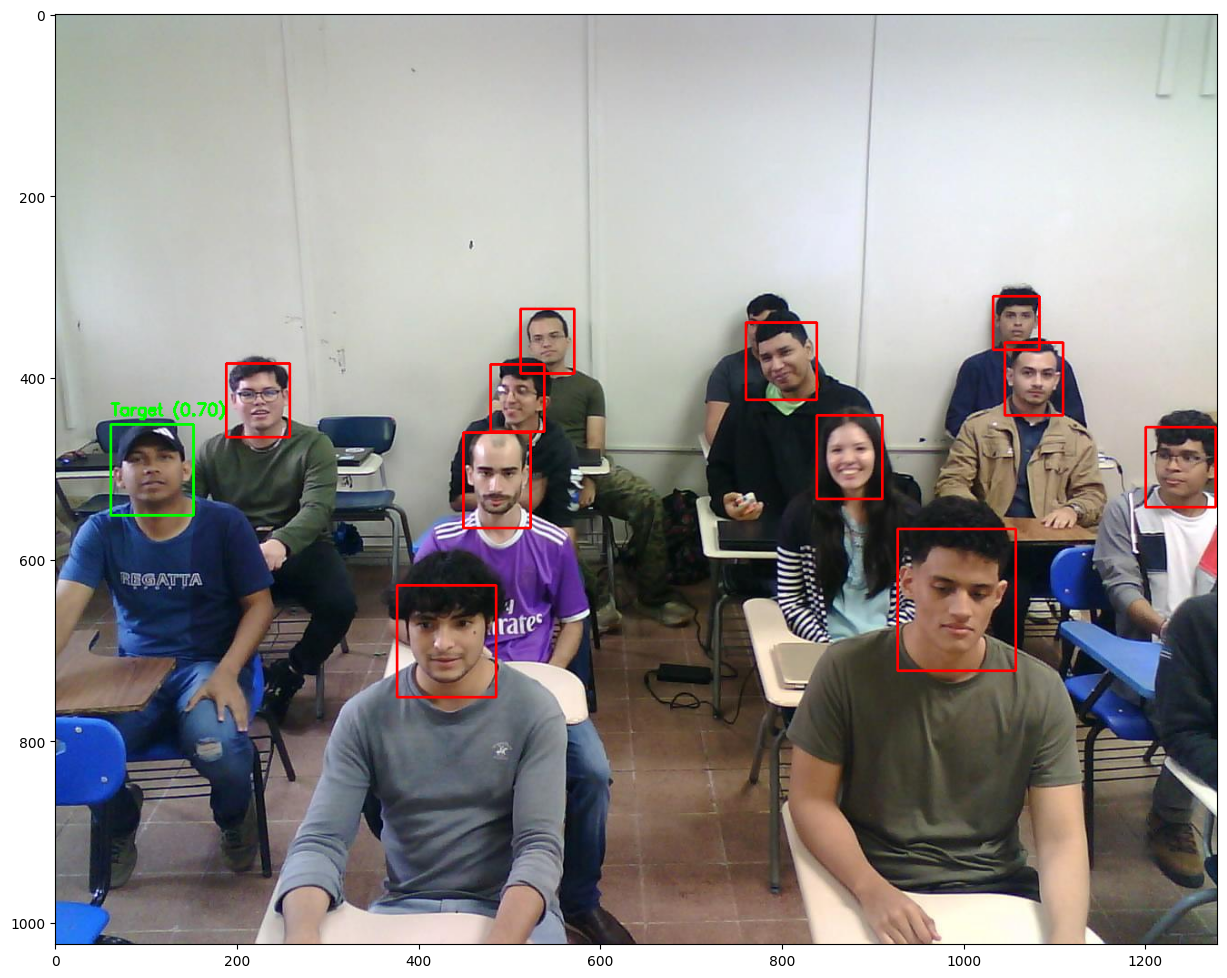

Index: 3 Distance: 0.3042
Index: 1 Distance: 0.5056
Index: 7 Distance: 0.5523
Index: 11 Distance: 0.6170
Index: 9 Distance: 0.6317
Index: 10 Distance: 0.6495
Index: 5 Distance: 0.6817
Index: 4 Distance: 0.6870
Index: 2 Distance: 0.7513
Index: 0 Distance: 0.8681
Index: 6 Distance: 1.0158
Index: 8 Distance: 1.0513


In [10]:
metrics = ["cosine", "euclidean", "euclidean_l2"]
models = ["Facenet", "Facenet512", "VGG-Face", "OpenFace", "DeepFace", "DeepID", "ArcFace", "Dlib", "SFace","GhostFaceNet"]

# Cargar la imagen a analizar
image = cv2.imread("./data/classroom/rawdata/s2/recording_2024-11-13_10-45-09/frame-224.jpg")

#extraer los rostros de la imagen a analizar
print("Extracting faces...")
faces = extract_and_expand_faces("./data/classroom/rawdata/s2/recording_2024-11-13_10-45-09/frame-224.jpg", 0.2)

#extraer el rostro objetivo (face_target) de la imagen de referencia
print("Extracting reference face...")
target_face_data =  extract_and_expand_faces("./data/classroom/ref/paredes-jeisson/img-00.png", 0.18)
name_person = "Target"

# Inicializar la lista para almacenar los resultados
results = []

print("Comparing images...")
# Asegurarse de que se detectó el rostro objetivo
if len(target_face_data) > 0:
    target_face = target_face_data[0]['face']  # Obtener el rostro objetivo

    bgr_target_face = (target_face*255.0).astype(np.uint8)
    
    total_faces:int = len(faces)
    i:int = 0
    #iterar sobre cada rostro detectado en la imagen
    for face_data in faces:

        loading = str.format("{0:.3f}", ((i+0.0)/(0.0+total_faces-1.0))*100.0)
        print("\r" + loading + "%", end="")
        
        facial_area = face_data['facial_area']  #Obtener el area facial (bounding box)
        face = face_data['face']  #Obtener el rostro extraido
        bgr_face = (face*255.0).astype(np.uint8)
        
        # Realizar la comparación (verificación) entre el rostro detectado y el rostro objetivo
        result = DeepFace.verify(
            img1_path=bgr_target_face,
            img2_path=bgr_face,
            detector_backend="skip",  #omitir la deteccion ya que estan los rostros
            model_name="Facenet512",
            distance_metric="cosine",
            threshold=0.44,
            enforce_detection=True
        )

        results.append([i, result['distance'], result['threshold'], 'cosine'])
        
        #si coinciden (verified=True), dibujar un rectángulo verde, sino, dibujar uno rojo
        x, y, w, h = facial_area['x'], facial_area['y'], facial_area['w'], facial_area['h']
        if result['verified']:
            color = (0, 255, 0)  # Verde
            name = name_person  # Nombre del estudiante objetivo
            confidence = 1.0-result.get('distance', 0)
            label = f"{name} ({confidence:.2f})"  # Nombre y confianza
            cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        else:
            color = (0, 0, 255)  # Rojo
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        
        i += 1

    results.sort(key=lambda x: x[1])
    
    #convertir la imagen de BGR a RGB para visualizarla con Matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    #Mostrar la imagen con los recuadros
    plt.figure(figsize=(15, 15))
    plt.imshow(image_rgb)
    plt.axis(True)
    plt.show()
    
    for res in results:
        print(f"Index: {res[0]} Distance: {res[1]:.4f}")
    
else:
    print("The target face was not detected.")